<a href="https://colab.research.google.com/github/juanglondono-coder/deep-learning-final-ydl-air-pollution/blob/main/04_modelo_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0. Importar librerias

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras import layers, models

# Crear carpeta de resultados si no existe
os.makedirs("results", exist_ok=True)

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


1. Carga de datos y preprocesado básico

In [2]:
# 1. Cargar datos
df = pd.read_csv('train.csv')

print("Shape original:", df.shape)
df.head()

Shape original: (6218, 14)


,Unnamed: 0,Datetime,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,0,2004-03-10 18:00:00,2.6,1360.00,150,11.881723,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,1,2004-03-10 19:00:00,2.0,1292.25,112,9.397165,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2,2004-03-10 20:00:00,2.2,1402.00,88,8.997817,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,3,2004-03-10 21:00:00,2.2,1375.50,80,9.228796,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,4,2004-03-10 22:00:00,1.6,1272.25,51,6.518224,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [3]:
# 1.1. Eliminar índice viejo si existe
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# 1.2. Convertir Datetime y ordenar por tiempo
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.sort_values('Datetime').reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6218 entries, 0 to 6217
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Datetime      6218 non-null   datetime64[ns]
 1   CO(GT)        6218 non-null   float64       
 2   PT08.S1(CO)   6218 non-null   float64       
 3   NMHC(GT)      6218 non-null   int64         
 4   C6H6(GT)      6218 non-null   float64       
 5   NOx(GT)       6218 non-null   float64       
 6   PT08.S3(NOx)  6218 non-null   float64       
 7   NO2(GT)       6218 non-null   float64       
 8   PT08.S4(NO2)  6218 non-null   float64       
 9   PT08.S5(O3)   6218 non-null   float64       
 10  T             6218 non-null   float64       
 11  RH            6218 non-null   float64       
 12  AH            6218 non-null   float64       
dtypes: datetime64[ns](1), float64(11), int64(1)
memory usage: 631.6 KB


In [4]:
# 1.3. Reemplazar -200 por NaN en columnas donde este valor indica dato inválido
cols_with_minus200 = ['CO(GT)', 'NMHC(GT)', 'NOx(GT)', 'NO2(GT)']

for c in cols_with_minus200:
    if c in df.columns:
        df[c] = df[c].replace(-200, np.nan)

df[cols_with_minus200].describe()

,CO(GT),NMHC(GT),NOx(GT),NO2(GT)
count,4771.000000,887.000000,4812.000000,4809.000000
mean,2.126200,218.607666,195.608479,99.113745
std,1.437417,206.615130,185.525983,41.416704
min,0.100000,7.000000,2.000000,2.000000
25%,1.100000,66.000000,75.000000,68.000000
50%,1.800000,145.000000,137.000000,96.000000
75%,2.800000,297.000000,246.000000,124.000000
max,11.900000,1189.000000,1389.000000,288.000000


2. Definir target, filtrar filas válidas y preparar features

In [5]:
target_col = 'NMHC(GT)'

# 2.1. Eliminar filas donde el target es NaN
df = df[~df[target_col].isna()].copy()
print("Shape después de filtrar filas sin target:", df.shape)

df[target_col].describe()

Shape después de filtrar filas sin target: (887, 13)


,NMHC(GT)
count,887.000000
mean,218.607666
std,206.615130
min,7.000000
25%,66.000000
50%,145.000000
75%,297.000000
max,1189.000000


In [6]:
# 2.2. Definir columnas de entrada (todas menos Datetime y el target)
feature_cols = [c for c in df.columns if c not in ['Datetime', target_col]]
print("Features:", feature_cols)

Features: ['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']


In [7]:
# 2.3. Separar X_raw e y
X_raw = df[feature_cols]
y = df[target_col]

In [8]:
# Imputador con mediana
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X_raw)

# Escalador estándar (media 0, varianza 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Volver a DataFrame escalado por comodidad
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols, index=df.index)

print("NaNs en X_scaled_df:", X_scaled_df.isna().sum().sum())  # debería ser 0

NaNs en X_scaled_df: 0


4. Crear ventanas temporales para LSTM

In [9]:
def create_windows(df_features, df_target, feature_cols, target_col, window_size=24):
    """
    df_features: DataFrame con las features (ya escaladas e imputadas)
    df_target: Serie con el target, mismo índice que df_features
    feature_cols: lista de nombres de columnas de features
    target_col: nombre de la columna objetivo
    window_size: número de pasos hacia atrás (ej. 24 horas)

    Devuelve:
        X_seq: array (n_samples, window_size, n_features)
        y_seq: array (n_samples,)
    """
    data = df_features[feature_cols].copy()
    data[target_col] = df_target.values

    values = data[feature_cols + [target_col]].values
    n_features = len(feature_cols)

    X_list, y_list = [], []

    for i in range(window_size, len(values)):
        # ventana: [i-window_size, ..., i-1]
        X_window = values[i-window_size:i, :n_features]
        # target: valor en el instante i
        y_value = values[i, -1]

        X_list.append(X_window)
        y_list.append(y_value)

    X_seq = np.array(X_list)
    y_seq = np.array(y_list)

    return X_seq, y_seq

In [10]:
window_size = 24  # puedes cambiarlo y comparar modelos

X_seq, y_seq = create_windows(
    df_features=X_scaled_df,
    df_target=y,
    feature_cols=feature_cols,
    target_col=target_col,
    window_size=window_size
)

print("X_seq shape:", X_seq.shape)  # (n_samples, window_size, n_features)
print("y_seq shape:", y_seq.shape)  # (n_samples,)


X_seq shape: (863, 24, 11)
y_seq shape: (863,)


5. Split train / valid / test respetando el tiempo

In [11]:
n_samples = X_seq.shape[0]

train_size = int(n_samples * 0.7)
val_size   = int(n_samples * 0.15)
test_size  = n_samples - train_size - val_size

print("train_size:", train_size)
print("val_size  :", val_size)
print("test_size :", test_size)

train_size: 604
val_size  : 129
test_size : 130


In [12]:
X_train = X_seq[:train_size]
y_train = y_seq[:train_size]

X_val   = X_seq[train_size:train_size + val_size]
y_val   = y_seq[train_size:train_size + val_size]

X_test  = X_seq[train_size + val_size:]
y_test  = y_seq[train_size + val_size:]

print("X_train:", X_train.shape)
print("X_val  :", X_val.shape)
print("X_test :", X_test.shape)

X_train: (604, 24, 11)
X_val  : (129, 24, 11)
X_test : (130, 24, 11)


6. Iteraciones con datos crudos

6.1. Iteraciones de modelo GRU

6.1.1. Definir el modelo de deep learning (GRU)

In [13]:
n_timesteps = X_train.shape[1]   # window_size
n_features  = X_train.shape[2]   # número de columnas

model = models.Sequential([
    layers.Input(shape=(n_timesteps, n_features)),
    layers.GRU(64, return_sequences=False),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mae',
    metrics=['mae']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        14,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,897 (66.00 KB)

 Trainable params: 16,897 (66.00 KB)

 Non-trainable params: 0 (0.00 B)

6.1.2. Entrenamiento con early stopping

In [14]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 190.4012 - mae: 190.4012 - val_loss: 322.3203 - val_mae: 322.3203
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 183.0937 - mae: 183.0937 - val_loss: 321.6746 - val_mae: 321.6746
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 202.6789 - mae: 202.6789 - val_loss: 320.6692 - val_mae: 320.6692
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 186.3174 - mae: 186.3174 - val_loss: 319.0152 - val_mae: 319.0152
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 177.5159 - mae: 177.5159 - val_loss: 315.8085 - val_mae: 315.8085
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 185.5209 - mae: 185.5209 - val_loss: 312.0304 - val_mae: 312.0304
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 172.2578 - mae: 172.2578 - val_loss: 308.3494 - val_mae: 308.3494
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 183.1929 - mae: 183.1929 - val_loss: 304.7268 - val_mae: 304.7268

6.1.3. Evaluación y gráficas

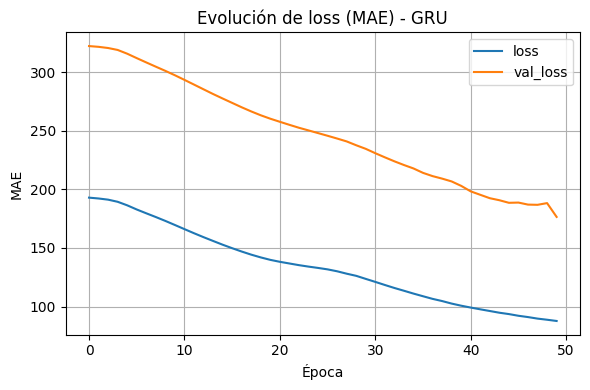

In [15]:
# Curvas de entrenamiento (loss vs val_loss)
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(6,4))
plt.xlabel('Época')
plt.ylabel('MAE')
plt.title('Evolución de loss (MAE) - GRU')
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
#Métricas en train / val / test
def eval_model(model, X, y, name=""):
    y_pred = model.predict(X, verbose=0).ravel()
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred)) # Corrected line
    print(f"{name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    return mae, rmse, y_pred

mae_train, rmse_train, y_pred_train = eval_model(model, X_train, y_train, "Train")
mae_val,   rmse_val,   y_pred_val   = eval_model(model, X_val,   y_val,   "Val")
mae_test,  rmse_test,  y_pred_test  = eval_model(model, X_test,  y_test,  "Test")

Train - MAE: 87.0861, RMSE: 156.9381
Val - MAE: 176.4908, RMSE: 276.6696
Test - MAE: 126.5788, RMSE: 210.9637


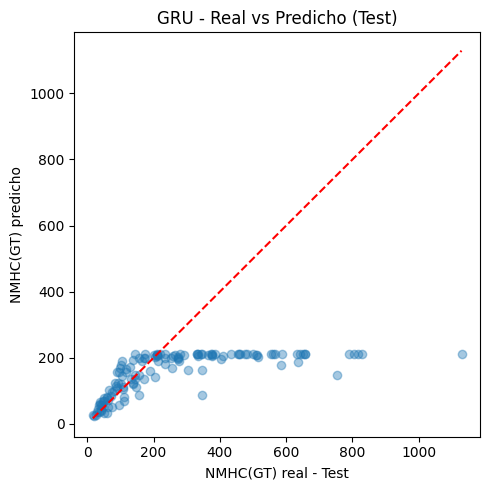

In [17]:
#Real vs predicho en test
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred_test, alpha=0.4)
plt.xlabel('NMHC(GT) real - Test')
plt.ylabel('NMHC(GT) predicho')
plt.title('GRU - Real vs Predicho (Test)')

min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.tight_layout()
plt.show()

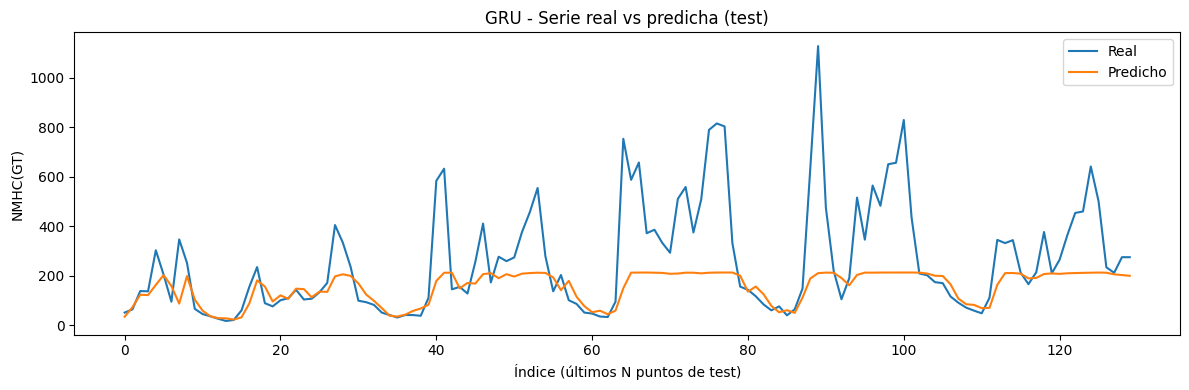

In [18]:
#Serie temporal comparando real vs predicho (últimos N puntos)
N = 200  # número de puntos para visualizar

plt.figure(figsize=(12,4))
plt.plot(y_test[-N:], label='Real')
plt.plot(y_pred_test[-N:], label='Predicho')
plt.xlabel('Índice (últimos N puntos de test)')
plt.ylabel('NMHC(GT)')
plt.title('GRU - Serie real vs predicha (test)')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
dl_metrics = pd.DataFrame({
    'set':   ['train', 'val', 'test'],
    'MAE':   [mae_train, mae_val, mae_test],
    'RMSE':  [rmse_train, rmse_val, rmse_test],
    'model': ['GRU'] * 3
})

dl_metrics

,set,MAE,RMSE,model
0,train,87.086079,156.938141,GRU
1,val,176.490785,276.669646,GRU
2,test,126.578759,210.963708,GRU


6.2. Iteraciones de modelo LSTM

6.2.1. Definir el modelo de deep learning (LSTM)

In [20]:
n_timesteps = X_train.shape[1]   # window_size
n_features  = X_train.shape[2]   # número de columnas

model = models.Sequential([
    layers.Input(shape=(n_timesteps, n_features)),
    layers.LSTM(64, return_sequences=False),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mae',
    metrics=['mae']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,569 (84.25 KB)

 Trainable params: 21,569 (84.25 KB)

 Non-trainable params: 0 (0.00 B)

6.2.2. Entrenamiento con early stopping

In [21]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 188.8279 - mae: 188.8279 - val_loss: 322.0479 - val_mae: 322.0479
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 187.3098 - mae: 187.3098 - val_loss: 320.7177 - val_mae: 320.7177
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 185.9082 - mae: 185.9082 - val_loss: 318.0891 - val_mae: 318.0891
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 186.9799 - mae: 186.9799 - val_loss: 313.6395 - val_mae: 313.6395
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 177.2901 - mae: 177.2901 - val_loss: 305.4208 - val_mae: 305.4208
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 183.6727 - mae: 183.6727 - val_loss: 297.1586 - val_mae: 297.1586
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 173.9318 - mae: 173.9318 - val_loss: 289.5328 - val_mae: 289.5328
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 162.6550 - mae: 162.6550 - val_loss: 282.2659 - val_mae: 282.2659

6.2.3. Evaluación y gráficas

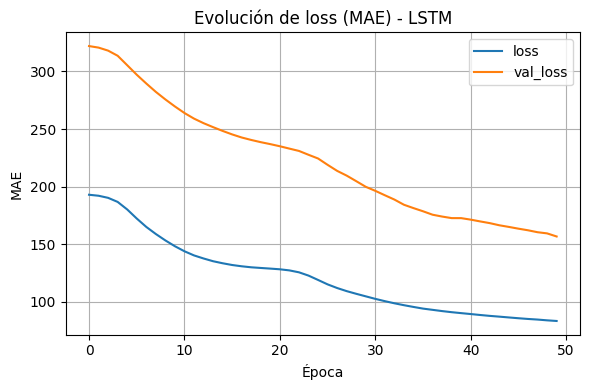

In [22]:
# Curvas de entrenamiento (loss vs val_loss)
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(6,4))
plt.xlabel('Época')
plt.ylabel('MAE')
plt.title('Evolución de loss (MAE) - LSTM')
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
#Métricas en train / val / test
def eval_model(model, X, y, name=""):
    y_pred = model.predict(X, verbose=0).ravel()
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred)) # Corrected line
    print(f"{name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    return mae, rmse, y_pred

mae_train, rmse_train, y_pred_train = eval_model(model, X_train, y_train, "Train")
mae_val,   rmse_val,   y_pred_val   = eval_model(model, X_val,   y_val,   "Val")
mae_test,  rmse_test,  y_pred_test  = eval_model(model, X_test,  y_test,  "Test")

Train - MAE: 82.9237, RMSE: 141.6021
Val - MAE: 156.6459, RMSE: 247.6192
Test - MAE: 116.3821, RMSE: 190.6513


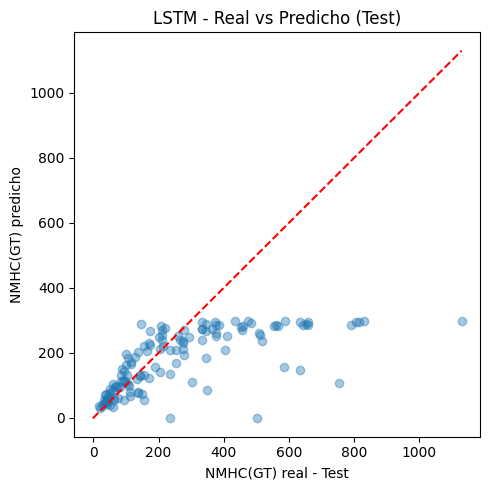

In [24]:
#Real vs predicho en test
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred_test, alpha=0.4)
plt.xlabel('NMHC(GT) real - Test')
plt.ylabel('NMHC(GT) predicho')
plt.title('LSTM - Real vs Predicho (Test)')

min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.tight_layout()
plt.show()

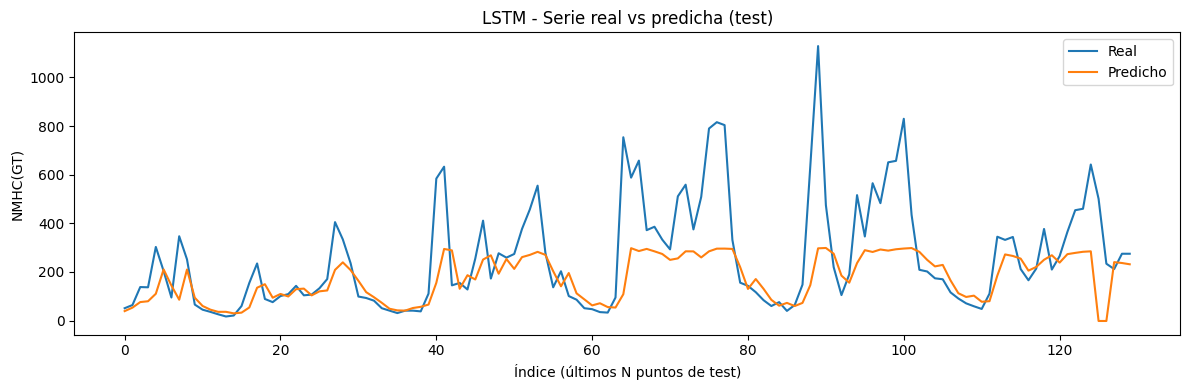

In [25]:
#Serie temporal comparando real vs predicho (últimos N puntos)
N = 200  # número de puntos para visualizar

plt.figure(figsize=(12,4))
plt.plot(y_test[-N:], label='Real')
plt.plot(y_pred_test[-N:], label='Predicho')
plt.xlabel('Índice (últimos N puntos de test)')
plt.ylabel('NMHC(GT)')
plt.title('LSTM - Serie real vs predicha (test)')
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
dl_metrics = pd.DataFrame({
    'set':   ['train', 'val', 'test'],
    'MAE':   [mae_train, mae_val, mae_test],
    'RMSE':  [rmse_train, rmse_val, rmse_test],
    'model': ['LSTM'] * 3
})

dl_metrics

,set,MAE,RMSE,model
0,train,82.923696,141.602059,LSTM
1,val,156.645926,247.619166,LSTM
2,test,116.382069,190.651305,LSTM


7. Iteración con transformación del target

7.1. Crear el target transformado

In [27]:
# Transformación logarítmica del target
# y_seq viene del paso anterior: target en escala original
y_seq_log = np.log1p(y_seq)   # log(1 + y), seguro para valores >= 0

In [28]:
print("Ejemplo y_seq[0:5]:     ", y_seq[:5])
print("Ejemplo y_seq_log[0:5]:", y_seq_log[:5])

Ejemplo y_seq[0:5]:      [307. 461. 401. 197.  61.]
Ejemplo y_seq_log[0:5]: [5.73009978 6.13556489 5.99645209 5.28826703 4.12713439]


In [29]:
# Usamos los mismos tamaños de split que antes
n_samples = X_seq.shape[0]

train_size = int(n_samples * 0.7)
val_size   = int(n_samples * 0.15)
test_size  = n_samples - train_size - val_size

In [30]:
# Split para features (igual que antes)
X_train = X_seq[:train_size]
X_val   = X_seq[train_size:train_size + val_size]
X_test  = X_seq[train_size + val_size:]

# Split para el target transformado
y_train_log = y_seq_log[:train_size]
y_val_log   = y_seq_log[train_size:train_size + val_size]
y_test_log  = y_seq_log[train_size + val_size:]

# Y guardamos también el target real (sin log) para las métricas
y_train_real = y_seq[:train_size]
y_val_real   = y_seq[train_size:train_size + val_size]
y_test_real  = y_seq[train_size + val_size:]

In [31]:
print("Shapes X_train, y_train_log:", X_train.shape, y_train_log.shape)

Shapes X_train, y_train_log: (604, 24, 11) (604,)


7.2. Iteraciones de modelo LSTM

7.2.1. Definir un nuevo modelo LSTM para el target transformado

In [32]:
from tensorflow.keras import layers, models

n_timesteps = X_train.shape[1]
n_features  = X_train.shape[2]

In [33]:
model_log = models.Sequential([
    layers.Input(shape=(n_timesteps, n_features)),
    layers.LSTM(64, return_sequences=False),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model_log.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',        # muchas veces funciona bien con el target en log
    metrics=['mae']
)

In [34]:
model_log.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,569 (84.25 KB)

 Trainable params: 21,569 (84.25 KB)

 Non-trainable params: 0 (0.00 B)

7.2.2. Entrenamiento con early stopping

In [35]:
early_stop_log = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_log = model_log.fit(
    X_train, y_train_log,
    validation_data=(X_val, y_val_log),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop_log],
    verbose=1
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 22.8353 - mae: 4.6773 - val_loss: 23.8672 - val_mae: 4.7755
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 13.9285 - mae: 3.4473 - val_loss: 14.6807 - val_mae: 3.3661
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.1566 - mae: 1.5670 - val_loss: 2.0003 - val_mae: 1.0479
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.9769 - mae: 0.7982 - val_loss: 1.3905 - val_mae: 0.9932
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7248 - mae: 0.6711 - val_loss: 0.4266 - val_mae: 0.5070
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4873 - mae: 0.5568 - val_loss: 0.3485 - val_mae: 0.4646
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.4215 - mae: 0.5179 - val_loss: 0.5057 - val_mae: 0.5727
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.3723 - mae: 0.4812 - val_loss: 0.4475 - val_mae: 0.5410
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0

7.2.3. Curvas de entrenamiento para el modelo con log

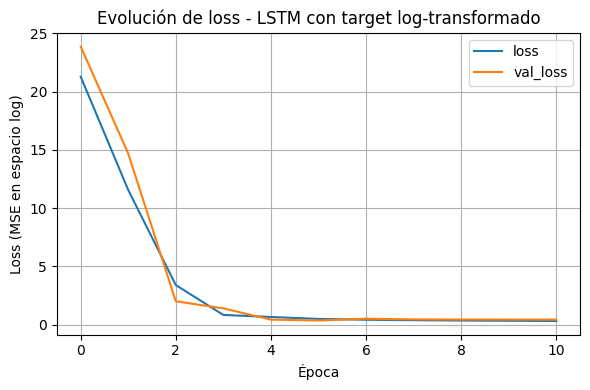

In [36]:
history_log_df = pd.DataFrame(history_log.history)
history_log_df[['loss', 'val_loss']].plot(figsize=(6,4))
plt.xlabel('Época')
plt.ylabel('Loss (MSE en espacio log)')
plt.title('Evolución de loss - LSTM con target log-transformado')
plt.grid(True)
plt.tight_layout()
plt.show()

7.2.4. Función de evaluación volviendo al espacio original

In [37]:
def eval_model_logspace(model, X, y_log, y_real, name=""):
    """
    model: modelo entrenado con y_log
    X: features (secuencias)
    y_log: target en escala log (no lo usamos para la métrica, solo por simetría)
    y_real: target en escala original
    """
    # Predicción en espacio log
    y_pred_log = model.predict(X, verbose=0).ravel()
    # Volver a espacio real
    y_pred = np.expm1(y_pred_log)

    mae = mean_absolute_error(y_real, y_pred)
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))

    print(f"{name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    return mae, rmse, y_pred

7.2.5. Métricas en train / val / test (escala original)

In [38]:
mae_train_log, rmse_train_log, y_pred_train_log = eval_model_logspace(
    model_log, X_train, y_train_log, y_train_real, name="Train (log target)"
)

mae_val_log, rmse_val_log, y_pred_val_log = eval_model_logspace(
    model_log, X_val, y_val_log, y_val_real, name="Val (log target)"
)

mae_test_log, rmse_test_log, y_pred_test_log = eval_model_logspace(
    model_log, X_test, y_test_log, y_test_real, name="Test (log target)"
)

Train (log target) - MAE: 95.6792, RMSE: 150.5608
Val (log target) - MAE: 139.7244, RMSE: 213.5942
Test (log target) - MAE: 124.1851, RMSE: 196.5047


7.2.6. Gráfica real vs predicho (test) para el modelo con log

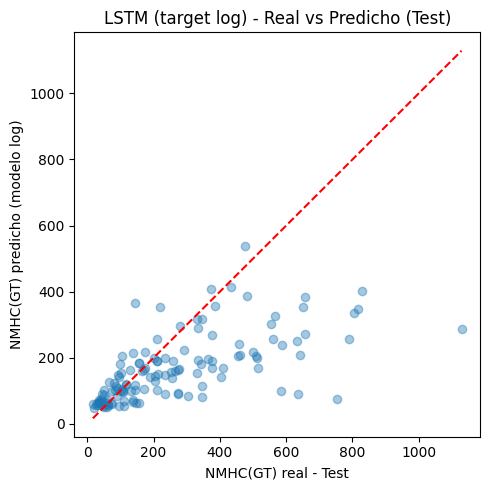

In [39]:
# Scatter
plt.figure(figsize=(5,5))
plt.scatter(y_test_real, y_pred_test_log, alpha=0.4)
plt.xlabel('NMHC(GT) real - Test')
plt.ylabel('NMHC(GT) predicho (modelo log)')
plt.title('LSTM (target log) - Real vs Predicho (Test)')

min_val = min(y_test_real.min(), y_pred_test_log.min())
max_val = max(y_test_real.max(), y_pred_test_log.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.tight_layout()
plt.show()

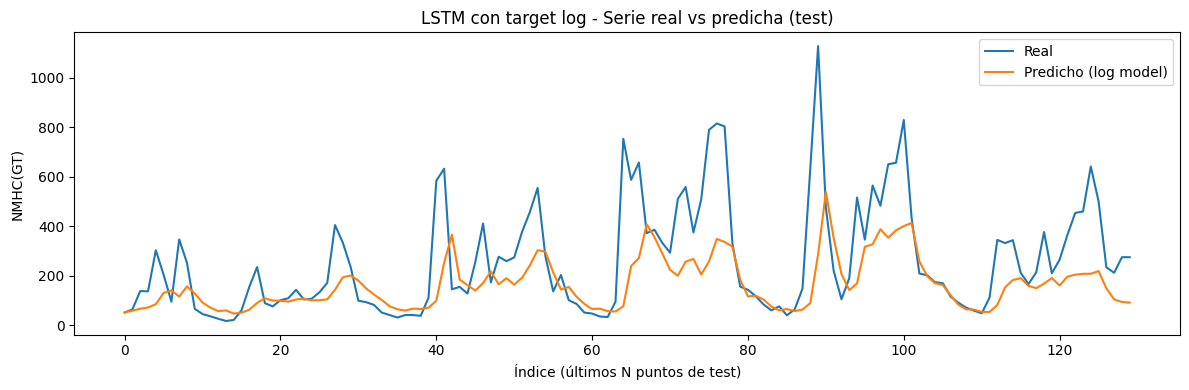

In [40]:
# Serie temporal de los últimos N puntos
N = 200

plt.figure(figsize=(12,4))
plt.plot(y_test_real[-N:], label='Real')
plt.plot(y_pred_test_log[-N:], label='Predicho (log model)')
plt.xlabel('Índice (últimos N puntos de test)')
plt.ylabel('NMHC(GT)')
plt.title('LSTM con target log - Serie real vs predicha (test)')
plt.legend()
plt.tight_layout()
plt.show()

7.2.7. Guardar métricas de esta iteración en el CSV

In [41]:
# Cargar métricas anteriores si existen
dl_metrics_path = os.path.join("results", "dl_metrics.csv")
if os.path.exists(dl_metrics_path):
    dl_metrics_prev = pd.read_csv(dl_metrics_path)
else:
    dl_metrics_prev = pd.DataFrame()

In [42]:
# Nuevas métricas del modelo con target log
dl_metrics_log = pd.DataFrame({
    'set':   ['train', 'val', 'test'],
    'MAE':   [mae_train_log, mae_val_log, mae_test_log],
    'RMSE':  [rmse_train_log, rmse_val_log, rmse_test_log],
    'model': ['LSTM_log_target'] * 3
})

7.3. Iteraciones de modelo GRU

7.3.1. Definir un nuevo modelo GRU para el target transformado

In [43]:
from tensorflow.keras import layers, models

n_timesteps = X_train.shape[1]
n_features  = X_train.shape[2]

In [44]:
model_log = models.Sequential([
    layers.Input(shape=(n_timesteps, n_features)),
    layers.GRU(64, return_sequences=False),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model_log.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',        # muchas veces funciona bien con el target en log
    metrics=['mae']
)

In [45]:
model_log.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 64)             │        14,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,897 (66.00 KB)

 Trainable params: 16,897 (66.00 KB)

 Non-trainable params: 0 (0.00 B)

7.3.2. Entrenamiento con early stopping

In [46]:
early_stop_log = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_log = model_log.fit(
    X_train, y_train_log,
    validation_data=(X_val, y_val_log),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop_log],
    verbose=1
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 24.0105 - mae: 4.7966 - val_loss: 22.4370 - val_mae: 4.6495
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 16.3999 - mae: 3.9053 - val_loss: 13.7250 - val_mae: 3.5185
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 10.7579 - mae: 3.0067 - val_loss: 6.8824 - val_mae: 2.1176
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.5642 - mae: 1.9887 - val_loss: 4.1638 - val_mae: 1.5444
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.3645 - mae: 1.5304 - val_loss: 2.9773 - val_mae: 1.2726
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.6939 - mae: 1.0633 - val_loss: 2.1986 - val_mae: 1.1642
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.0055 - mae: 0.7867 - val_loss: 1.3446 - val_mae: 0.9522
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.7509 - mae: 0.7011 - val_loss: 1.1250 - val_mae: 0.8746
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 

7.3.3. Curvas de entrenamiento para el modelo con log

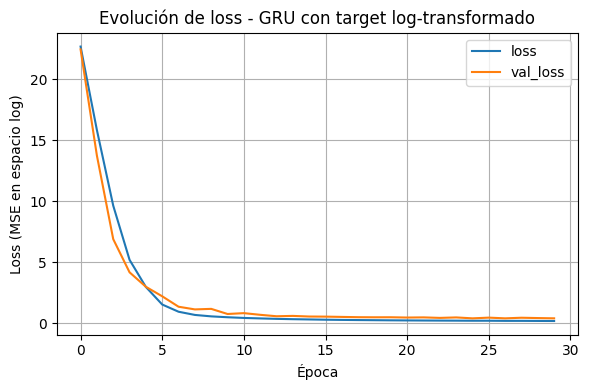

In [47]:
history_log_df = pd.DataFrame(history_log.history)
history_log_df[['loss', 'val_loss']].plot(figsize=(6,4))
plt.xlabel('Época')
plt.ylabel('Loss (MSE en espacio log)')
plt.title('Evolución de loss - GRU con target log-transformado')
plt.grid(True)
plt.tight_layout()
plt.show()

7.3.4. Función de evaluación volviendo al espacio original

In [48]:
def eval_model_logspace(model, X, y_log, y_real, name=""):
    """
    model: modelo entrenado con y_log
    X: features (secuencias)
    y_log: target en escala log (no lo usamos para la métrica, solo por simetría)
    y_real: target en escala original
    """
    # Predicción en espacio log
    y_pred_log = model.predict(X, verbose=0).ravel()
    # Volver a espacio real
    y_pred = np.expm1(y_pred_log)

    mae = mean_absolute_error(y_real, y_pred)
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))

    print(f"{name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    return mae, rmse, y_pred

7.3.5. Métricas en train / val / test (escala original)

In [49]:
mae_train_log, rmse_train_log, y_pred_train_log = eval_model_logspace(
    model_log, X_train, y_train_log, y_train_real, name="Train (log target)"
)

mae_val_log, rmse_val_log, y_pred_val_log = eval_model_logspace(
    model_log, X_val, y_val_log, y_val_real, name="Val (log target)"
)

mae_test_log, rmse_test_log, y_pred_test_log = eval_model_logspace(
    model_log, X_test, y_test_log, y_test_real, name="Test (log target)"
)

Train (log target) - MAE: 65.0483, RMSE: 105.1156
Val (log target) - MAE: 139.1860, RMSE: 217.2970
Test (log target) - MAE: 100.6289, RMSE: 158.1459


7.3.6. Gráfica real vs predicho (test) para el modelo con log

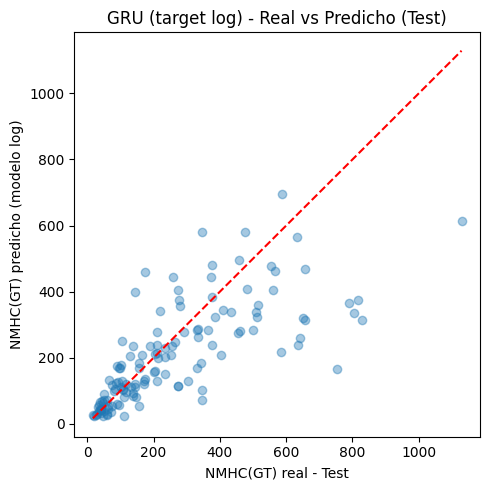

In [50]:
# Scatter
plt.figure(figsize=(5,5))
plt.scatter(y_test_real, y_pred_test_log, alpha=0.4)
plt.xlabel('NMHC(GT) real - Test')
plt.ylabel('NMHC(GT) predicho (modelo log)')
plt.title('GRU (target log) - Real vs Predicho (Test)')

min_val = min(y_test_real.min(), y_pred_test_log.min())
max_val = max(y_test_real.max(), y_pred_test_log.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.tight_layout()
plt.show()

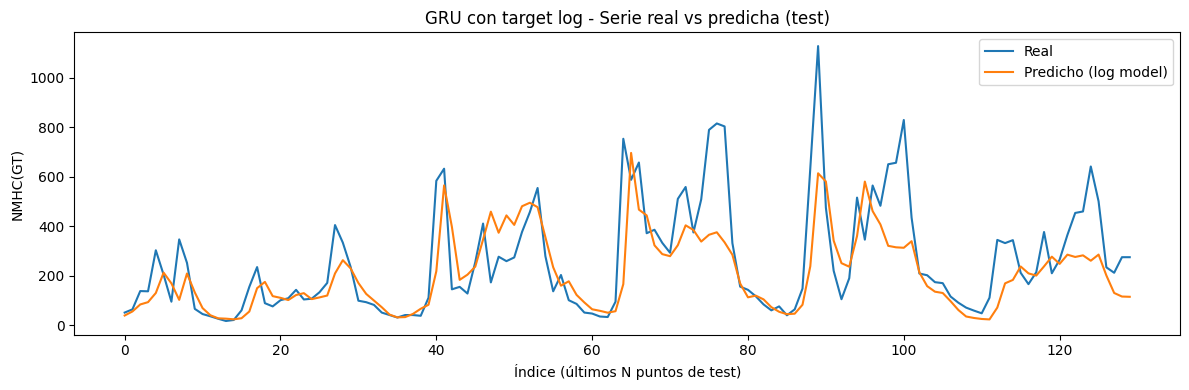

In [51]:
# Serie temporal de los últimos N puntos
N = 200

plt.figure(figsize=(12,4))
plt.plot(y_test_real[-N:], label='Real')
plt.plot(y_pred_test_log[-N:], label='Predicho (log model)')
plt.xlabel('Índice (últimos N puntos de test)')
plt.ylabel('NMHC(GT)')
plt.title('GRU con target log - Serie real vs predicha (test)')
plt.legend()
plt.tight_layout()
plt.show()

7.3.7. Guardar métricas de esta iteración en el CSV

In [52]:
# Cargar métricas anteriores si existen
dl_metrics_path = os.path.join("results", "dl_metrics.csv")
if os.path.exists(dl_metrics_path):
    dl_metrics_prev = pd.read_csv(dl_metrics_path)
else:
    dl_metrics_prev = pd.DataFrame()

In [53]:
# Nuevas métricas del modelo con target log
dl_metrics_log = pd.DataFrame({
    'set':   ['train', 'val', 'test'],
    'MAE':   [mae_train_log, mae_val_log, mae_test_log],
    'RMSE':  [rmse_train_log, rmse_val_log, rmse_test_log],
    'model': ['GRU_log_target'] * 3
})

In [54]:
# Concatenar y guardar
dl_metrics_all = pd.concat([dl_metrics_prev, dl_metrics_log], ignore_index=True)
dl_metrics_all.to_csv(dl_metrics_path, index=False)

dl_metrics_all

,set,MAE,RMSE,model
0,train,90.656479,139.276349,LSTM_log_target
1,val,135.533818,203.248473,LSTM_log_target
2,test,112.146975,170.723877,LSTM_log_target
3,train,55.502747,86.559023,GRU_log_target
4,val,124.051552,192.483544,GRU_log_target
5,test,94.611093,149.235741,GRU_log_target
6,train,74.670044,127.889422,LSTM_log_target
7,val,143.177579,220.417195,LSTM_log_target
8,test,113.083401,181.068188,LSTM_log_target
9,train,53.304303,87.036877,GRU_log_target


8. Sumatoria de metricas

In [55]:
# Cargar métricas de baseline (notebook 03)
baseline_metrics = pd.read_csv('baseline_metrics.csv')

# Cargar métricas de deep learning (notebook 04)
dl_path = os.path.join("results", "dl_metrics.csv")
dl_metrics_all = pd.read_csv(dl_path)

# Nos quedamos con el set 'test' para comparar modelos
baseline_test = baseline_metrics.copy()
baseline_test['set'] = 'test'   # si no lo tenías

In [56]:
dl_test = dl_metrics_all[dl_metrics_all['set'] == 'test'].copy()

In [57]:
# Unir todo en una sola tabla
all_test_metrics = pd.concat([baseline_test, dl_test], ignore_index=True)

all_test_metrics

,model,MAE,RMSE,set
0,RandomForest,29.118333,49.793278,test
1,LinearRegression,56.525761,86.436374,test
2,LSTM_log_target,112.146975,170.723877,test
3,GRU_log_target,94.611093,149.235741,test
4,LSTM_log_target,113.083401,181.068188,test
5,GRU_log_target,96.235047,155.747289,test
6,LSTM_log_target,117.693866,187.731618,test
7,GRU_log_target,88.252976,133.683190,test
8,GRU_log_target,100.628870,158.145861,test


In [58]:
best_baseline = baseline_test.loc[baseline_test['MAE'].idxmin()]

mae_baseline = best_baseline['MAE']
rmse_baseline = best_baseline['RMSE']

mae_gru = all_test_metrics.loc[all_test_metrics['model']=='GRU_log_target', 'MAE'].iloc[0]
rmse_gru = all_test_metrics.loc[all_test_metrics['model']=='GRU_log_target', 'RMSE'].iloc[0]

In [59]:
print("Mejor baseline:", best_baseline['model'])
print("MAE baseline:", mae_baseline, " RMSE baseline:", rmse_baseline)
print("MAE GRU_log_target:", mae_gru, " RMSE:", rmse_gru)

print("Mejora relativa MAE:  {:.1f}%".format(100*(mae_baseline - mae_gru)/mae_baseline))
print("Mejora relativa RMSE: {:.1f}%".format(100*(rmse_baseline - rmse_gru)/rmse_baseline))

Mejor baseline: RandomForest
MAE baseline: 29.118333333333336  RMSE baseline: 49.7932775126892
MAE GRU_log_target: 94.61109303694504  RMSE: 149.23574099431812
Mejora relativa MAE:  -224.9%
Mejora relativa RMSE: -199.7%
